In [1]:
import numpy as np
import json

In [2]:
from matplotlib import pyplot as plt

# System

In [3]:
def write_system(file: str, db: dict) -> None: 
    offset = 0.05   # Abstand z-Linie von Systemlinie

    with open(file, 'w') as f:
        f.write('#   x,    y\n')
        for stab in (db['sofimshc']['staebe']).items():
            f.write(f'# Stab {stab[0]}\n')
            for lr in ('l', 'r'):
                x = db['sofimshc']['knoten'][str(stab[1][lr])]['x']
                y = db['sofimshc']['knoten'][str(stab[1][lr])]['z']
                f.write(f'{x:.3f} {y:.3f}\n')
            f.write('\n')

            for lr in ('l', 'r'):
                x = db['sofimshc']['knoten'][str(stab[1][lr])]['x'] + np.sin(np.radians(stab[1]['alpha']))*offset
                y = db['sofimshc']['knoten'][str(stab[1][lr])]['z'] + np.cos(np.radians(stab[1]['alpha']))*offset
                f.write(f'{x:.3f} {y:.3f}\n')
            f.write('\n')

## Auflager

In [4]:
support_Z = [
    (0, 0, 0.75, 1),
    (0, 0, -0.75, 1),
    (0.75, 1, -0.75, 1),
    (1.2, 1.3, -1.2, 1.3),
]

support_XZ = [
    (0    , 0, 0.75, 1),
    (0    , 0, -0.75, 1),
    (1.2  , 1, -1.2, 1),
    (-0.8 , 1, -1.1, 1.3),
    (-0.35, 1, -0.65, 1.3),
    ( 0.1 , 1, -0.2, 1.3),
    ( 0.55, 1,  0.25, 1.3),
    ( 1.00, 1,  0.7, 1.3),
]

support_XY = [
    (0, 1.2, 0, -1.2),
    (-0.3, 1.2, -0.3, -1.2),
    (-0.3, -0.8, -0.6, -1.1),
    (-0.3, -0.35, -0.6, -0.65),
    (-0.3,  0.1, -0.6, -0.2),
    (-0.3, 0.55, -0.6, 0.25),
    (-0.3,  1.0, -0.6, 0.7),
]

support_XYZ = [
    (0, 1.2, 0, -1.2),
    (0, -0.8, -0.3, -1.1),
    (0, -0.35, -0.3, -0.65),
    (0,  0.1, -0.3, -0.2),
    (0, 0.55, -0.3, 0.25),
    (0,  1.0, -0.3, 0.7),
]

In [5]:
def rotate_support(lines: list, angle: float):
    new_lines = []
    rad = np.radians(angle)
    for line in lines:
        x_1 = line[0]*np.cos(rad) - line[1]*np.sin(rad)
        y_1 = line[0]*np.sin(rad) + line[1]*np.cos(rad)
        x_2 = line[2]*np.cos(rad) - line[3]*np.sin(rad)
        y_2 = line[2]*np.sin(rad) + line[3]*np.cos(rad)

        new_lines.append((x_1, y_1, x_2, y_2))

    return new_lines



def get_support_type(supports: dict):
    if supports == {'x': -1, 'z': -1, 'y': -1}: 
        return support_XYZ
    elif supports == {'x': -1, 'z': -1, 'y': 0}: 
        return support_XZ
    elif supports == {'x': -1, 'z': 0, 'y': -1}: 
        return support_XY
    elif supports == {'x': 0, 'z': -1, 'y': -1}: 
        return rotate_support(support_XY, -90)
    elif supports == {'x': 0, 'z': -1, 'y': 0}: 
        print('t')
        return support_Z 
    elif supports == {'x': -1, 'z': 0, 'y': 0}: 
        return rotate_support(support_Z, 90)



def support_text(knot: tuple):
    lines = get_support_type(knot[1]['sup'])
    if not(lines):
        return []
    lines = rotate_support(lines, knot[1]['alpha'])
    text = [f'# Knoten {knot[0]}\n']
    
    x = knot[1]['x']
    y = knot[1]['z']
    for line in lines: 
        for i in range(2):
            text.append(f'{x:.3f} {y:.3f} {line[2*i]:.3f} {line[2*i+1]:.3f}\n')
        text.append('\n')

    return text



def write_support(file: str, db: dict) -> None:
    with open(file, 'w') as f:
        f.write('#   x,    y, delta_x, delta_y\n')
        for knot in (db['sofimshc']['knoten']).items():
            f.writelines(support_text(knot))
            f.write('\n')

# Schnittgrößen ausgeben

In [6]:
def write_schnittgroessen(file: str, db: dict) -> None:
    with open(file, 'w') as f:
        f.write(f'# x,   y,    alpha, Schnittgroesse \n')
        for nr_stab, stab in db['sofimshc']['staebe'].items():
            for s in ('N', 'V', 'M'):
                f.write(f'# Stab {nr_stab}            {s}\n')

                alpha = db['sofimshc']['staebe'][nr_stab]['alpha']
                x_l = db['sofimshc']['knoten'][str(db['sofimshc']['staebe'][nr_stab]['l'])]['x']
                z_l = db['sofimshc']['knoten'][str(db['sofimshc']['staebe'][nr_stab]['l'])]['z']

                for i, point in enumerate(stab['points']):
                    x_i = x_l + np.cos(np.radians(alpha))*point
                    z_i = z_l - np.sin(np.radians(alpha))*point
                    s_i = db['ase']['1']['s'][nr_stab][s][i]

                    if i == 0:
                        f.write(f'{x_i:.3f}  {z_i:.3f}  {alpha:.3f}  0.000\n')
                    f.write(f'{x_i:.3f}  {z_i:.3f}  {alpha:.3f}  {s_i:.3f}\n')
                f.write(f'{x_i:.3f}  {z_i:.3f}  {alpha:.3f}  0.000\n')
                f.write(f'\n')

# Datenbasis laden

In [7]:
with open('db.json') as f:
    db = json.load(f)

In [8]:
write_system('system.gpd', db)

In [9]:
write_support('support.gpd', db)

In [10]:
write_schnittgroessen('schnittgroessen.gpd', db)

# Gnuplot

In [11]:
# Gnuplot-Befehl
#plot "structure.gpd" every:2 with lines notitle lt rgb 'black', '' every:2::1  with lines linetype rgb 'black' dashtype 2 notitle
# Kreis zeichnen
#set object 1 circle front at 0.5,0.5 size 0.1 fillcolor rgb "black" lw 1
# plot 'support.gpd' using ($1+factor*$3):($2+factor*$4) with lines notitle linetype rgb 'black' ,"structure.gpd" every:2 with lines notitle lt rgb 'black', '' every:2::1  with lines linetype rgb 'black' dashtype 2 notitle

# Lager

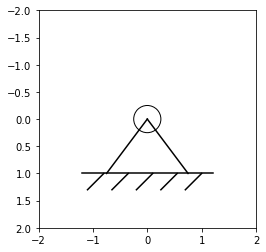

In [12]:
circle1 = plt.Circle((0,0), 0.25, fill=False)

plt.plot([0, 0.75], [0,1], 'k')
plt.plot([0, -0.75], [0,1], 'k-')
plt.plot([1.2, -1.2], [1,1], 'k-')

for i in range(5):
    plt.plot([-0.8+i*0.45, -1.1+i*0.45], [1,1.3], 'k-')
"""
    plt.plot([-0.45, -0.85], [1,1.4], 'k-')
    plt.plot([-0.9, -1.3], [1,1.4], 'k-')

    plt.plot([0.45, 0.05], [1,1.4], 'k-')
    plt.plot([0.9, 0.5], [1,1.4], 'k-')
"""


plt.axis('scaled')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax = plt.gca()
ax.invert_yaxis()
ax.add_patch(circle1)